**Projet NLP - M2 TIDE\
-AYEB Sabri\
-DIARRA Dioncounda\
-KORAIBI Kamar\
-YALAP Sophia**

In [1]:
#Import des librairies
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import re
from wordcloud import WordCloud
from spellchecker import SpellChecker
import itertools

# Partie I: Préparation de la table et exploration des données

In [2]:
#Importation des données puis concaténation des deux tables
#Création d'une variable cible, de valeur 1 si l'article est une fake news, 0 sinon
df_true=pd.read_csv("C:/Users/ddiarra/Documents/Projet_Python_TIDE/donnees/True.csv", sep=",")
df_fake=pd.read_csv("C:/Users/ddiarra/Documents/Projet_Python_TIDE/donnees/Fake.csv", sep=",")
df_true["target"]=0
df_fake["target"]=1
df=pd.concat([df_true, df_fake])
df["title"]=df["title"].astype(str)

In [3]:
#Permet d'observer les valeurs manquantes par colonne
print(round(df.isnull().mean() * 100, 2))
print(df.subject.unique())
df.head()

title      0.0
text       0.0
subject    0.0
date       0.0
target     0.0
dtype: float64
['politicsNews' 'worldnews' 'News' 'politics' 'Government News'
 'left-news' 'US_News' 'Middle-east']


,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


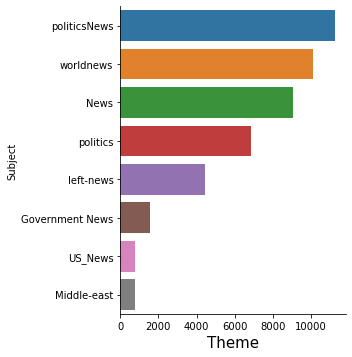

In [4]:
#On effectue un count afin d'obtenir le nombre d'occurrence de chaque sujet des articles
subject_count=df.subject.value_counts().rename_axis('Subject').reset_index(name='Percent')
sns.catplot(data=subject_count, kind='bar', x="Percent", y="Subject").set_xlabels('Theme', fontsize=15)

C:\Users\ddiarra\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


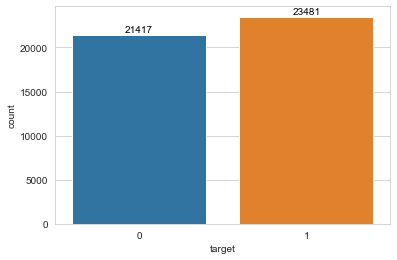

In [5]:
#Permet d'obtenir la fréquence des fakenews (target=1) et des vraies news (target=0)
sns.set_style('whitegrid')
ax = sns.countplot(df['target'])
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

In [6]:
#Création d'une nouvelle variable qui contient la longueur de chaque article 
df['length'] = df['title'].apply(len)

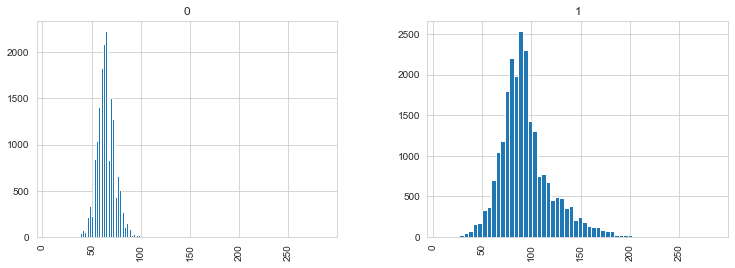

In [7]:
#On regarde la distribution du nombre de mots en fonction de la variable target (1=fakenews pour rappel)
df.hist(column='length',by='target',bins=60,figsize=(12,4),sharex=True);

# Partie II: Nettoyage du texte, début de la partie NLP

In [8]:
#On charge le langage anglais de spacy
nlp=spacy.load("en_core_web_sm")

Fonction de lemmatisation, permet de garder la racine et de supprimer les mots superflus

In [9]:
#Tokenise le texte, chaque mot est transformé en token
# Garde les valeurs non numériques, les mots de plus de 2 lettres et les mots qui ne font pas partie de la liste de 
# stop words (mots superflus tels que les déterminants, mots de liaison)
#Cela permet de réduire le nombre de paramètres du modèle (nombre de mots)
def lemmatize(doc) -> list:
    return [token.lemma_ for token in doc if token.is_alpha and len(token.text)>2 and not token.is_stop]

In [16]:
#On applique la lemmatisation qu'on stock dans une nouvelle colonne et on transforme en miniscules tous les mots
df["lemma"]=df.title.apply(lambda x:lemmatize(nlp(x)))
df["lemma"]=df["lemma"].apply(lambda x :list(y.lower() for y in x) )

In [23]:
#Permet de "délister" les tokens
df.lemma=[', '.join(map(str, l)) for l in df['lemma'] ] 
df.lemma

0        budget, fight, loom, republicans, flip, fiscal...
1        military, accept, transgender, recruit, monday...
2           senior, republican, senator, let, mueller, job
3        fbi, russia, probe, help, australian, diplomat...
4        trump, want, postal, service, charge, amazon, ...
                               ...                        
23476    mcpain, john, mccain, furious, iran, treat, sa...
23477    justice, yahoo, settles, mail, privacy, class,...
23478    sunnistan, allied, safe, zone, plan, territori...
23479    blow, million, jazeera, america, finally, call...
23480    navy, sailor, hold, iranian, military, sign, n...
Name: lemma, Length: 44898, dtype: object

In [24]:
#Permet d'obtenir les 20 mots les plus représentés, on remarque que certains mots reviennent capitalisés ou non
df.lemma.str.split(', ' ,expand=True).stack().value_counts().nlargest(20,)

trump         14886
video          8480
say            3882
obama          3240
hillary        2363
watch          2013
house          2006
clinton        1802
new            1784
white          1689
president      1681
russia         1339
state          1310
bill           1306
vote           1179
election       1152
republican     1115
call           1079
north          1034
court          1024
dtype: int64

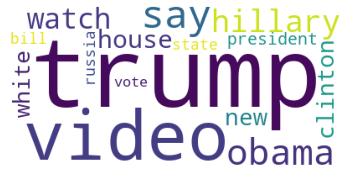

In [25]:
#Permet d'obtenir un nuage de mots, les mots sur-représentés s'affichent dans une taille plus grosse 
stacked_words=df.lemma.str.split(', ' ,expand=True).stack().value_counts().nlargest(20,)
cloudofwords=WordCloud(background_color='white', max_words=15).fit_words(stacked_words)
plt.imshow(cloudofwords)
plt.axis('off')
plt.show()

# Partie III: Modèle de classification 

In [26]:
import snowballstemmer
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix, 
    balanced_accuracy_score, 
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score, 
    f1_score,
    log_loss,
    plot_roc_curve,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [27]:
#On sépare le dataset en plusieurs morceaux, selon une proportion 75% pour la phase d'apprentissage, 25% pour la phase de test, comme nous avons presque 
# 45 000 observations
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['target'], random_state=42)
df_train = df_train.copy()
df_test = df_test.copy()

In [28]:
#On vérifie la taille de la partie test et train
print("Taille dataset TRAIN:", len(df_train))
print("Taille dataset TEST:", len(df_test))

Taille dataset TRAIN: 33673
Taille dataset TEST: 11225


In [29]:
#On se prépare à mettre sous forme de vecteur les différents mots
vectorizer=CountVectorizer()

In [30]:
#On crée un vecteur qui aura un nombre de colonnes égal au nombre de mots distincts de la variable lemma
vec = vectorizer.fit(
    pd.concat([df_train['lemma'], df_test['lemma']])
)

In [31]:
#On vectorise la partie training et test, lorsqu'un mot issu du dataset est retrouvé, la colonne associée au mot prend la valeur 1, sinon 0
X_train = vec.transform(df_train['lemma'])
X_test = vec.transform(df_test['lemma'])
y_train=df_train['target']
y_test=df_test['target']

Préparation modélisation

In [32]:
#Modélisation avec le Random forest 
model_rfc = RandomForestClassifier(random_state=1)
model_rfc.fit(X_train, y_train)
y_test_pred_rfc = model_rfc.predict(X_test)
y_pred_prob_rfc = model_rfc.predict_proba(X_test)[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_prob_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
precision_rfc, recall_rfc, th_rfc = precision_recall_curve(y_test, y_pred_prob_rfc)

In [33]:
#Modélisation avec la régression logistique
model_lr=LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(X_train, y_train)
y_test_pred_lr = model_lr.predict(X_test)
y_pred_prob_lr = model_lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(y_test, y_pred_prob_lr)

In [34]:
#Modélisation avec l'arbre décisionnel
model_dt=DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_test_pred_dt = model_dt.predict(X_test)
y_pred_prob_dt = model_dt.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
precision_dt, recall_dt, th_dt = precision_recall_curve(y_test, y_pred_prob_dt)

In [43]:
#Modélisation avec le naive bayesian
X_train_nb=X_train.toarray()
X_test_nb=X_test.toarray()
y_test_nb=y_test
model_nb= GaussianNB()
model_nb.fit(X_train_nb,y_train)
y_test_pred_nb = model_nb.predict(X_test_nb)
y_pred_prob_nb = model_nb.predict_proba(X_test_nb)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_nb, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(y_test_nb, y_pred_prob_nb)

In [47]:
#Calcule de différentes métrics qui permettent de juger de la qualité de la modélisation
classifier=['Random forest classifier', 'Logistic regression', 'Decision tree', 'Naive bayesian']
accuracy=[accuracy_score(y_test, y_test_pred_dt), accuracy_score(y_test, y_test_pred_lr), accuracy_score(y_test, y_test_pred_rfc), accuracy_score(y_test, y_test_pred_nb)]
precision=[precision_score(y_test, y_test_pred_dt), precision_score(y_test, y_test_pred_lr), precision_score(y_test, y_test_pred_rfc), precision_score(y_test, y_test_pred_nb)]
recall=[recall_score(y_test, y_test_pred_dt), recall_score(y_test, y_test_pred_lr), recall_score(y_test, y_test_pred_rfc), recall_score(y_test, y_test_pred_nb)]
f1=[f1_score(y_test, y_test_pred_dt), f1_score(y_test, y_test_pred_lr), f1_score(y_test, y_test_pred_rfc), f1_score(y_test, y_test_pred_nb)]
auc=[roc_auc_dt, roc_auc_lr, roc_auc_rfc, roc_auc_nb]
table=pd.DataFrame({'Classifier':classifier, 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'f1':f1, 'AUC':auc})
table

,Classifier,Accuracy,Precision,Recall,f1,AUC
0,Random forest classifier,0.907350,0.900913,0.924544,0.912576,0.906519
1,Logistic regression,0.951893,0.961399,0.946006,0.953640,0.990421
2,Decision tree,0.937906,0.947268,0.933231,0.940197,0.984787
3,Naive bayesian,0.871269,0.943665,0.801737,0.866931,0.874707


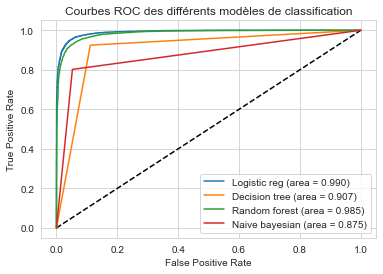

In [46]:
#Plot des courbes ROG, représentant le taux de vrais positifs et le taux de faux positifs
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic reg (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_dt, tpr_dt, label='Decision tree (area = %0.3f)' % roc_auc_dt)
plt.plot(fpr_rfc, tpr_rfc, label='Random forest (area = %0.3f)' % roc_auc_rfc)
plt.plot(fpr_nb, tpr_nb, label='Naive bayesian (area = %0.3f)' % roc_auc_nb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC des différents modèles de classification')
plt.legend(loc='best')
plt.show()

In [45]:
#Fonction permettant de représenter une matrice de confusion
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion Matrix',
                         cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                ha="center",
                color="white" if cm[i,j]> thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


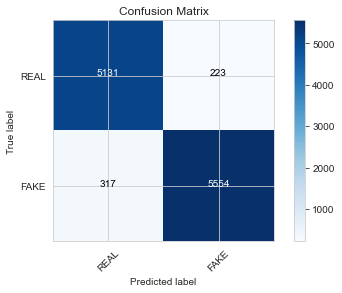

In [42]:
#Représentation de la matrice de confusion pour le modèle le plus précis, c'est à dire la régression logistique
cm = metrics.confusion_matrix(y_test,y_test_pred_lr)
plot_confusion_matrix(cm, classes=['REAL','FAKE'])